In [1]:
from datautils import get_dls
from src.models.resnet import ResNet
from src.models.patchTST import PatchTST
from src.learner import  transfer_weights
import torch.nn as nn
from src.basics import set_device
import torch

from src.callback.patch_mask import Patch
#set_device()

class params:
    def __init__(self, **kwargs):
        for key in kwargs:
            setattr(self, key, kwargs[key])

In [2]:
dls = get_dls(params(batch_size=1, dset='ham', num_workers=1, context_points=341)) 
#dls = get_dls(params(batch_size=1, dset='ettm1', num_workers=1, classification=0.05, context_points=336, target_points=2, features='M')) 

In [3]:
model_rsnt = ResNet(1, 'classification', 2, .2)
model_ptst = PatchTST(c_in=1,
                target_dim=2,
                patch_len=8,
                stride=4,
                num_patch=106,                
                n_layers=3,
                n_heads=16,
                d_model=128,
                shared_embedding=True,
                d_ff=256,                        
                dropout=.2,
                head_dropout=0,
                act='relu',
                head_type='classification',
                res_attention=False
                )    

In [4]:
w_path_rsnt = 'saved_models/gunpoint/resnet/based_model/resnet_cw150_epochs-pretrain20_model1.pth'
w_path_ptst = 'saved_models/gunpoint/patchtst_supervised/based_model/patchtst_supervised_cw150_tw2_patch16_stride8_epochs30_model1.pth'
w_path_pretrain_ = 'saved_models/ettm1/masked_patchtst/classification/ettm1_patchtst_finetuned_cw336_tw2_patch16_stride8_epochs-finetune20_model1.pth'
w_path_resnet_ettm1 = 'saved_models/ettm1/resnet/based_model/resnet_cw336_epochs-pretrain20_model1.pth'
w_path_ptst_comp = 'saved_models/computers/patchtst_supervised/classification/patchtst_supervised_cw720_tw2_patch8_stride4_epochs50_model1.pth'
w_path_rsnt_comp = 'saved_models/computers/resnet/based_model/resnet_cw720_epochs-pretrain50_model1.pth'

w_path_ptst_ham = 'saved_models/ham/patchtst_supervised/classification/patchtst_supervised_cw431_tw2_patch8_stride4_epochs50_model1.pth'
w_path_rsnt_ham = 'saved_models/ham/resnet/based_model/resnet_cw431_epochs-pretrain50_model1.pth'


model_ptst = transfer_weights(weights_path=w_path_ptst_ham, model=model_ptst, exclude_head=False, device='cuda')
model_rsnt = transfer_weights(weights_path=w_path_rsnt_ham, model=model_rsnt, exclude_head=False, device='cuda')



weights from saved_models/ham/patchtst_supervised/classification/patchtst_supervised_cw431_tw2_patch8_stride4_epochs50_model1.pth successfully transferred!

weights from saved_models/ham/resnet/based_model/resnet_cw431_epochs-pretrain50_model1.pth successfully transferred!



In [5]:
model_ptst.eval()
model_rsnt.eval()

ResNet(
  (block1): ResNetBlock(
    (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResNetBlock(
    (conv1): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 1

In [6]:
from scipy.spatial.distance import pdist, cdist, squareform

In [7]:
class GAP_Resnet(nn.Module):

    def __init__(self, model):
        super(GAP_Resnet, self).__init__()

        self.model = model
        self.flatten = nn.Flatten(start_dim=1)

    def _one_forward(self, x):
        chan_cat_out = torch.zeros(x.shape[0], x.shape[1], 128, device='cpu')
        for chan in range(x.shape[1]):
            out = self.model.block1(x[:, chan, :].unsqueeze(1))
            out = self.model.block2(out)
            out = self.model.block3(out)
            out = self.model.gap(out)
            chan_cat_out[:, chan, :] = out
        return chan_cat_out
        

    def forward(self, x):
        x = x.permute(0,2,1)

        out = self._one_forward(x)
        out = self.flatten(out)

        return out

In [9]:
class GAP_PatchTST(nn.Module):

    def __init__(self, model):
        super(GAP_PatchTST, self).__init__()

        self.model = model.backbone
        self.patch = Patch(seq_len = 431, patch_len = 8, stride = 4, )
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.patch(x)
        out = self.model(x)
        out = out[:,:,:,-1]            
        out = self.flatten(out)  
        return out

In [10]:
gap_m = GAP_Resnet(model_rsnt)

In [11]:
gap_p = GAP_PatchTST(model_ptst)

In [12]:
gap_p.cpu()
gap_m.cpu()

GAP_Resnet(
  (model): ResNet(
    (block1): ResNetBlock(
      (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(1,), padding=same, bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
      (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,), padding=same, bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (block2): ResNetBlock(
      (conv1): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=same, bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True,

In [15]:
dl = iter(dls.test)

In [16]:
N = 100
m = 20
X = []
X_GAP_ptst = []
X_GAP_rsnt = []
Y = []
n_pos = 0
i=0
eq = 1
while True :
    x, y = next(dl)
# if i%N ==0 :
#     if y == eq :
        #eq = 1 - eq
    x = x.unsqueeze(-1)
    #X.append(x.flatten(start_dim=1))
    Y.append(y)
    X_GAP_ptst.append(gap_p(x))
    X_GAP_rsnt.append(gap_m(x))
    X.append(x)
    if len(X)>=N:
        break



In [17]:
X_GAP_rsnt[1].shape

torch.Size([1, 128])

In [18]:
def to_numpy(l):
    return [el.detach().cpu().numpy( ) for el in l ]

In [19]:
X_GAP_ptst = to_numpy(X_GAP_ptst)
X_GAP_rsnt = to_numpy(X_GAP_rsnt)

In [20]:
Y = to_numpy(Y)
X = to_numpy(X)

In [21]:
import numpy as np

In [22]:
X = np.array(X)
X_GAP_ptst = np.array(X_GAP_ptst)
X_GAP_rsnt = np.array(X_GAP_rsnt)

In [24]:
X = X.reshape(N,431)
X_GAP_rsnt = X_GAP_rsnt.reshape(N,128)
X_GAP_ptst = X_GAP_ptst.reshape(N,128)

In [25]:
Xdist = squareform(pdist(X))

In [26]:
X_GAP_rsnt_dist = squareform(pdist(X_GAP_rsnt))
X_GAP_ptst_dist = squareform(pdist(X_GAP_ptst))

In [27]:
def stress(Xdist, X_GAP_dist):
    d_norm = np.sum(X_GAP_dist**2)
    up = np.sum((X_GAP_dist-Xdist)**2)
    return np.sqrt(up/d_norm)

In [28]:
stress(Xdist, X_GAP_dist)

NameError: name 'X_GAP_dist' is not defined

In [32]:
from sklearn.manifold import MDS

mds_gap = MDS(dissimilarity='precomputed', random_state=0)

X_ptst_transform = mds_gap.fit_transform(X_GAP_ptst_dist)

X_rsnt_transform = mds_gap.fit_transform(X_GAP_rsnt_dist)

In [33]:
import matplotlib.pyplot as plt

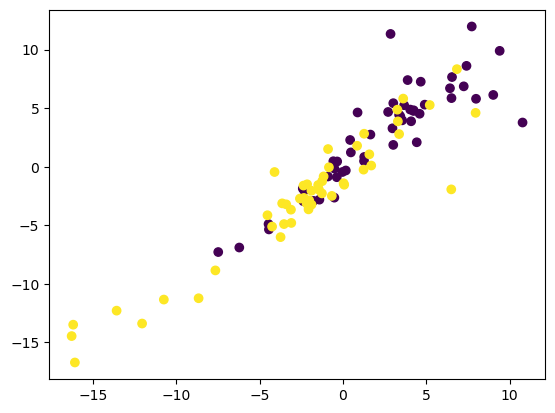

In [34]:
plt.scatter(X_ptst_transform[:,0], X_ptst_transform[:,1], c=np.ravel(Y))
plt.show()

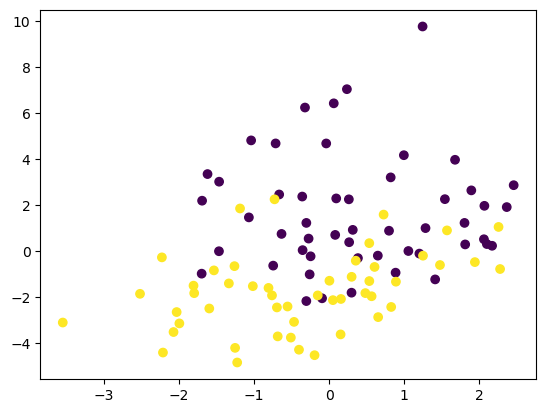

In [35]:
plt.scatter(X_rsnt_transform[:,0], X_rsnt_transform[:,1], c=np.ravel(Y))
plt.show()

In [36]:
mds_raw = MDS(random_state=0)
X_transform = mds_raw.fit_transform(X)

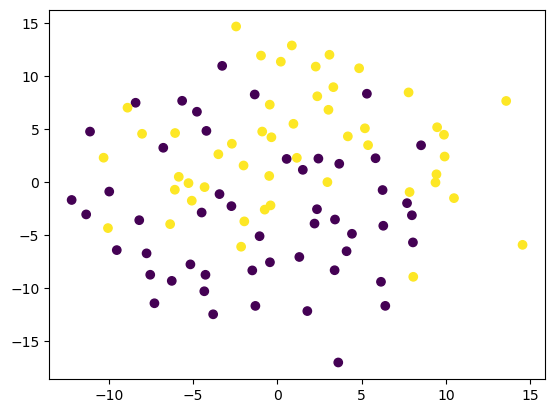

In [37]:
plt.scatter(X_transform[:,0], X_transform[:,1], c=np.ravel(Y))
plt.show()